In [ ]:
import os
import re
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from langchain.docstore.document import Document
from langchain.embeddings import OpenAIEmbeddings

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score



In [ ]:
os.environ["OPENAI_API_KEY"] = json.load(open('../config/openai_api.json', 'r'))["OPENAI_API_KEY"]

### Preparing video metadata

In [ ]:
def find_episode_name(s):
    pattern = r'Episode(.*?),\s*Segment'
    result = re.search(pattern, s)
    if result:
        return result.group(1).strip()
    else:
        return None
    
def find_segment_name(s):
    pattern = r'Segment(.*?)\(\d{2}-\d{2}-\d{2}\s*\d{2}-\d{2}-\d{2}\)'
    result = re.search(pattern, s)
    if result:
        return result.group(1).strip()
    else:
        return None
    
def get_start_timestamp_in_s(s):
    pattern = r'\((\d{2})-(\d{2})-(\d{2})\s*\d{2}-\d{2}-\d{2}\)'
    result = re.search(pattern, s)
    if result:
        hours = int(result.group(1))
        minutes = int(result.group(2))
        seconds = int(result.group(3))
        total_seconds = (hours * 3600) + (minutes * 60) + seconds
        return total_seconds
    else:
        return None
    
def get_yt_url(video_id, start_timestamp):
    return f"https://www.youtube.com/watch?v={video_id}&t={start_timestamp}s"

def create_summary_docs_and_metadata(summary_directory):
    video_data = pd.read_csv('../data/video_metadata.csv')
    video_data['title'] = video_data['title'].apply(lambda x: x.replace("/", " ").replace(":", "-"))
    
    data = []
    docs = []
    for filename in os.listdir(summary_directory):
        if not filename.startswith('.'):
            episode_name = find_episode_name(filename)
            segment_name = find_segment_name(filename)
            video_id = video_data.loc[video_data['title'] == episode_name, "videoId"].to_list()[0]
            start_timestamp_s = get_start_timestamp_in_s(filename)
            url = get_yt_url(video_id, start_timestamp_s)
            full_path = os.path.join(summary_directory, filename)
            with open(full_path) as f:
                text = f.read()
            docs.append(Document(page_content=text, metadata={"episode_name": episode_name,
                                                              "segment_name": segment_name,
                                                              "url": url}))
            data.append([episode_name, segment_name, text, url])

    metadata = pd.DataFrame(data, columns=['episode_name', 'segment_name', 'summary', "url"])
    return metadata, docs

In [ ]:
summary_dir = os.path.join("..", "data", "summaries")
df_metadata, docs = create_summary_docs_and_metadata(summary_dir)

In [ ]:
df_metadata.to_csv('../data/summary_metadata.csv', index=False)

In [ ]:
docs

### OpenAI embeddings

In [ ]:
embeddings = OpenAIEmbeddings()
vectors = embeddings.embed_documents(texts=[doc.page_content for doc in docs])

In [ ]:
joblib.dump(vectors, os.path.join("..", "data", "embeddings", "summary_embeddings.joblib"))

In [ ]:
vectors_array = np.array(vectors)

### KMeans on embeddings

In [ ]:
num_clusters = 30
kmeans = KMeans(n_clusters=num_clusters,
                init='k-means++',
                n_init=10,
                random_state=42).fit(vectors_array)


# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(vectors_array)

/var/folders/zx/cp3jdxgx2sq3fds9frds7mg40000gn/T/ipykernel_38659/131856846.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', num_clusters)
/var/folders/zx/cp3jdxgx2sq3fds9frds7mg40000gn/T/ipykernel_38659/131856846.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=colors[i], label=i, alpha=0.7)


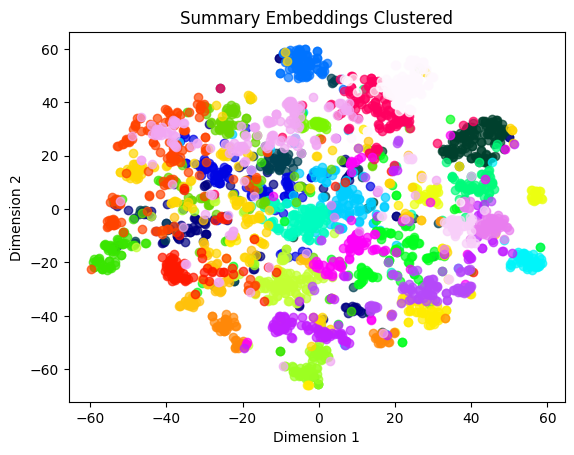

In [147]:
df_plot = pd.DataFrame(reduced_data_tsne)
df_plot['label'] = kmeans.labels_
cmap = plt.cm.get_cmap('gist_ncar', num_clusters)
colors = [cmap(i) for i in range(num_clusters)]

for i, df in df_plot.groupby("label"):
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=colors[i], label=i, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Summary Embeddings Clustered')
plt.show()

In [ ]:
kmeans.labels_[:10]

In [ ]:
df_metadata['k_means_label'] = kmeans.labels_

In [ ]:
df_sorted = df_metadata.sort_values(by=["k_means_label"]).reset_index(drop=True)

In [ ]:
df_sorted.to_csv('../data/summaries_kmeans.csv', index=False)

### Sample segments for giving ontology to ChatGPT

In [ ]:
df_na_dropped = df_sorted.dropna(subset=["segment_name"])

In [ ]:
for i in range(0, 30, 5):
    df_na_dropped[df_na_dropped["k_means_label"].isin(list(range(i, i+5)))].sample(200).loc[:, ["k_means_label", "segment_name"]].to_csv(f'../data/label_sample_{i}_{i+5}.csv', index=False)